In [1]:
import pandas as pd
import numpy as np
import os #Facilita a manipulação de caminhos

In [2]:
#Definição do caminho base para os dados brutos
data_dir = '../data/raw/'

#Dicionário para armazenar os Dataframes
data = {}

files = [
    'olist_customers_dataset.csv',
    'olist_geolocation_dataset.csv',
    'olist_order_items_dataset.csv',
    'olist_order_payments_dataset.csv',
    'olist_order_reviews_dataset.csv',
    'olist_orders_dataset.csv',
    'olist_products_dataset.csv',
    'olist_sellers_dataset.csv',
    'product_category_name_translation.csv'
]

#Loop para carregar cada arquivo
for file in files:
    file_path = os.path.join(data_dir, file)
    df_name = file.replace('.csv', '')
    data[df_name] = pd.read_csv(file_path)
    print(f"Carregado: {df_name} com {data[df_name].shape[0]} linhas.")

#Execução das fusões (merge)

#Tabela principal com Pedidos e Itens
df_main = data['olist_orders_dataset'].merge(
    data['olist_order_items_dataset'],
    on='order_id',
    how='left'
)

#Juntando a tabela principal com Clientes
df_main = df_main.merge(
    data['olist_customers_dataset'],
    on='customer_id',
    how='left'
)

#Juntando a tabela principal com Produtos e Tradução
df_main = df_main.merge(
    data['olist_products_dataset'],
    on='product_id',
    how='left'
)
df_main = df_main.merge(
    data['product_category_name_translation'],
    on='product_category_name',
    how='left'
)

#Pagamento e Avaliações
df_main = df_main.merge(
    data['olist_order_payments_dataset'],
    on='order_id',
    how='left'
)
df_main = df_main.merge(
    data['olist_order_reviews_dataset'],
    on='order_id',
    how='left'
)

print(f"\n--- Resultado da Fusão ---")
print(f"Tabela Mestra Final: {df_main.shape[0]} linhas e {df_main.shape[1]} colunas.")
print(df_main.head())

Carregado: olist_customers_dataset com 99441 linhas.
Carregado: olist_geolocation_dataset com 1000163 linhas.
Carregado: olist_order_items_dataset com 112650 linhas.
Carregado: olist_order_payments_dataset com 103886 linhas.
Carregado: olist_order_reviews_dataset com 99224 linhas.
Carregado: olist_orders_dataset com 99441 linhas.
Carregado: olist_products_dataset com 32951 linhas.
Carregado: olist_sellers_dataset com 3095 linhas.
Carregado: product_category_name_translation com 71 linhas.

--- Resultado da Fusão ---
Tabela Mestra Final: 119143 linhas e 37 colunas.
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a3

**Fase 1, Parte 2: Limpeza de Dados e Feature Engineering**

In [3]:
#Convertendo os tipos de dados (Datas)
date_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'review_creation_date',
    'review_answer_timestamp'
]

for col in date_cols:
    df_main[col] = pd.to_datetime(df_main[col], errors='coerce')

print("COnversão de datas concluídas")
print(df_main[date_cols].dtypes)

COnversão de datas concluídas
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
dtype: object


In [4]:
#Tratamento de Valores Nulos -> NaN ou NaT
null_counts = df_main[date_cols].isnull().sum()
null_percent = (null_counts / df_main.shape[0]) * 100

print("Contagem de Nulos nas Colunas de Data")
print(null_counts.sort_values(ascending=False).round(2))
print("Porcentagem de Nulos nas Colunas de Data")
print(null_percent.sort_values(ascending=False).round(2))

Contagem de Nulos nas Colunas de Data
order_delivered_customer_date    3421
order_delivered_carrier_date     2086
review_creation_date              997
review_answer_timestamp           997
order_approved_at                 177
order_purchase_timestamp            0
order_estimated_delivery_date       0
dtype: int64
Porcentagem de Nulos nas Colunas de Data
order_delivered_customer_date    2.87
order_delivered_carrier_date     1.75
review_creation_date             0.84
review_answer_timestamp          0.84
order_approved_at                0.15
order_purchase_timestamp         0.00
order_estimated_delivery_date    0.00
dtype: float64


In [5]:
#Preenchimento de categorias nulas
df_main['product_category_name_english'].fillna('no_category', inplace=True)

#Limpeza das linhas onde "order_id" ou "customer_id" estiver nulo
df_main.dropna(subset=['order_id', 'customer_id'], inplace=True)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_19716\391266583.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_main['product_category_name_english'].fillna('no_category', inplace=True)


In [6]:
#Analise Temporal
df_main['purchase_year'] = df_main['order_purchase_timestamp'].dt.year
df_main['purchase_month'] = df_main['order_purchase_timestamp'].dt.to_period('M')
df_main['purchase_dayofweek'] = df_main['order_purchase_timestamp'].dt.day_name()

In [7]:
#Métricas de Entregas (KPIs)
# - Tempo real de entrega (Em dias)
df_main['delivery_lead_time_days'] = (
    df_main['order_delivered_customer_date'] - df_main['order_purchase_timestamp']
).dt.days

# - Diferença entre a data de entrega e a data estimada (Perfomance de Logistica)
df_main['delivery_vs_estimated'] = (
    df_main['order_delivered_customer_date'] - df_main['order_estimated_delivery_date']
).dt.days

In [8]:
#Aqui vou fazer uma tabela agregada para Pagamentos/Receita no nível do pedido
df_revenue = df_main.groupby('order_id').agg(
    total_order_price=('price', 'sum'),
    total_order_freight=('freight_value', 'sum'),
    order_status=('order_status', 'first')
).reset_index()

df_revenue['Total_Revenue'] = df_revenue['total_order_price'] + df_revenue['total_order_freight']


*Fase 2: Análise Exploratória e KPIs*
Nesta fase vamos transformar os dados limpos em insights de negócio, usando estatística e visualização. 
O objetivo é responder às perguntas-chave de negócio (KPIs) definidas no escopo.

1. Análise da Performance de Vendas ao Longo do Tempo (Série Temporal)

In [9]:
#AGREGAÇÃO MENSAL
# Vamos filtrar apenas pedidos que estão 'delivered' (entregues) ou 'shipped' (enviados) para analisar a receita real.
# Embora pedidos cancelados sejam importantes, para a tendência de receita, focamos nos concluídos.
df_revenue['purchase_month'] = df_main['order_purchase_timestamp'].dt.to_period('M')
df_revenue_delivered = df_revenue[
    df_revenue['order_status'].isin(['delivered', 'shipped'])
]



#Agrupamento da receita total pelo mês da compra
revenue_by_month = df_revenue_delivered.groupby('purchase_month')['Total_Revenue'].sum().reset_index()
#Converti a coluna purchase_month para o tipo string para melhorar a visualização no eixo x
revenue_by_month['purchase_month'] = revenue_by_month['purchase_month'].astype(str)

print("Receita Mensal Agregada:")
print(revenue_by_month.head())

Receita Mensal Agregada:
  purchase_month  Total_Revenue
0        2016-09         783.42
1        2016-10       54759.98
2        2016-12          65.71
3        2017-01      145460.13
4        2017-02      313584.40


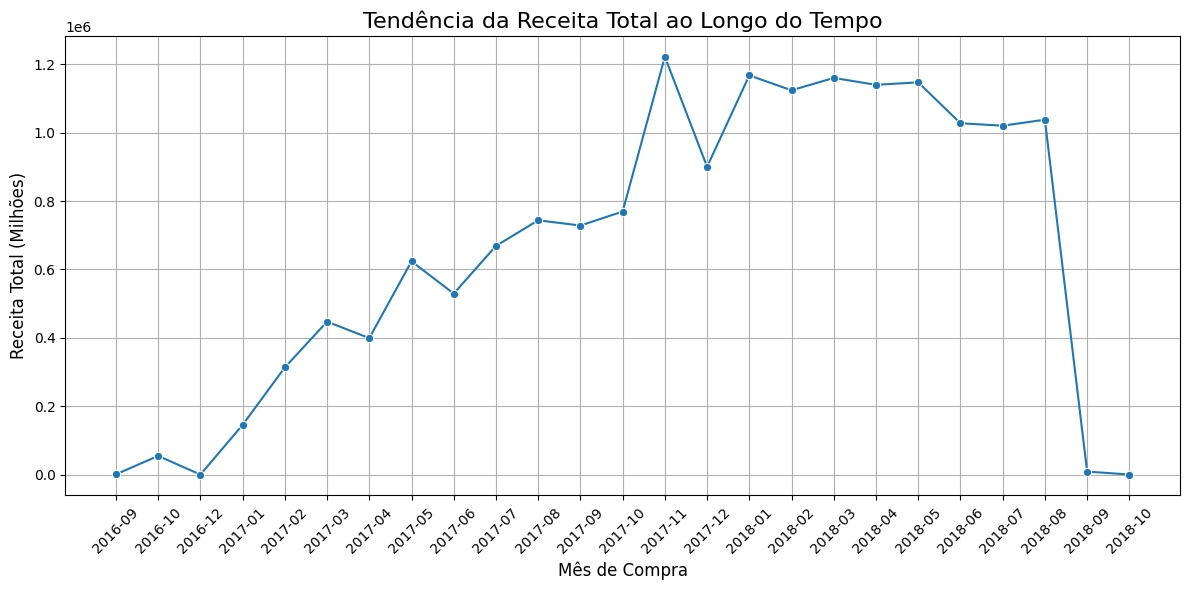

In [ ]:
#Visualização da Tendência - Gráfico de Linhas
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=revenue_by_month,
    x='purchase_month',
    y='Total_Revenue',
    marker='o'
)

plt.title('Tendência da Receita Total ao Longo do Tempo', fontsize=16)
plt.xlabel('Mês de Compra', fontsize=12)
plt.ylabel('Receita Total (Milhões)', fontsize=12)
plt.xticks(rotation=45) 
plt.grid(True)
plt.tight_layout()
plt.show()